In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# from bert import tokenization
# from .hackaton import tokenization
import tokenization

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow_addons as tfa
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kirill_Sergeev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kirill_Sergeev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
data_dir = 'dp-profi/data/'

In [18]:
os.listdir(data_dir)

['1.csv', '2.csv', 'deepy.csv', 'preparing_train.csv']

In [19]:
data = pd.read_csv(data_dir + 'preparing_train_with_context5.csv')

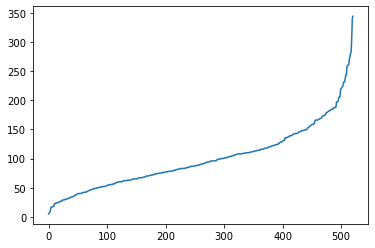

In [20]:
plt.plot(sorted([len(i) for  i in data['message']]))

In [21]:
data.drop('text_stemm', axis = 'columns', inplace = True)

In [22]:
data

,utterance_id,conversation_id,agent,message,topic,text_clean,text_lemm
0,0,0,agent_1,do you listen to albums?,Music,listen albums,listen album
1,1,0,agent_2,Yes I do. Have you listened to Hybrid Theory?,Music,yes listened hybrid theory,yes listen hybrid theory
2,2,0,agent_1,Yes it is the best selling album of the centur...,Music,yes best selling album century,yes good sell album century
3,3,0,agent_2,True. Do you know who Reel Big FIsh are?,Music,true know reel big fish,true know reel big fish
4,4,0,agent_1,Yes the band that lost the rights to their own...,Music,yes band lost rights music sad,yes band lose right music sad
...,...,...,...,...,...,...,...
516,516,22,agent_2,"Yeah it sure is, the majority of it has been c...",Politics,yeah sure majority cleared really sad nevada g...,yeah sure majority clear really sad nevada gov...
517,517,22,agent_1,Did you know wikileaks actually published the ...,Politics,know wikileaks actually published government p...,know wikileak actually publish government plan...
518,518,22,agent_2,Haha they are just too good. On the other hand...,Politics,good hand seems government granting much power...,good hand seem government grant much power per...
519,519,22,agent_1,"Something I can't wrap my brain around, is the...",Politics,something wrap brain around fact presidents gu...,something wrap brain around fact president gue...


In [23]:
data.dropna(inplace = True)

In [24]:
data.reset_index(drop = True, inplace = True)

In [25]:
target = data['message']
train = data.drop('topic', axis = 'columns')

In [26]:
def bert_encode(texts, tokenizer, max_len=160):
    all_tokens, all_masks, all_segments = [], [], []
    
    for text in tqdm(texts):
        # Tokenize the current text
        text = tokenizer.tokenize(text)
        # Select text only till 
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [27]:
%%time
url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(url, trainable=True)

Wall time: 36.3 s


In [28]:
vocab_fl = bert_layer.resolved_object.vocab_file.asset_path.numpy()
lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_fl, lower_case)

In [29]:
classes = data.topic.unique().tolist()

data['target'] = data.topic.map(lambda x: classes.index(x))

In [30]:
def encode_target(t_class):
    t_class=str(t_class)
    return class_dict[t_class]

In [31]:
n_classes = len(data['target'].value_counts())

In [40]:
max_len = 200

In [41]:
train_input = bert_encode(data['text_lemm'].values, tokenizer, max_len=max_len)
train_labels = data['target'].values

In [42]:
def build_model(transformer, max_len=max_len):

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_word_ids')
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name='input_mask')
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name='segment_ids')
    # Get the sequence output
    _, seq_op = transformer([input_word_ids, input_mask, segment_ids])
    # Get the respective class token from that sequence output
    class_tkn = seq_op[:, 0, :]
    # Final Neuron (for Classification)
    op = Dense(20, activation='softmax')(class_tkn)
    # Bind the inputs and outputs together into a Model
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=op)
    
    model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [43]:
model = build_model(bert_layer, max_len=max_len)

In [44]:
checkpoint = ModelCheckpoint('model_f1.h5', monitor='val_accuracy', save_best_only=True)


train_history = model.fit(
    train_input, train_labels,
    validation_split=0.33,
    epochs=10,
    shuffle=True,
    callbacks=[checkpoint],
    batch_size=16)

Epoch 1/10
22/22 [==============================] - 928s 42s/step - loss: 1.4170 - accuracy: 0.6501 - val_loss: 2.3525 - val_accuracy: 0.5029
Epoch 2/10
22/22 [==============================] - 919s 42s/step - loss: 1.3196 - accuracy: 0.6038 - val_loss: 3.0442 - val_accuracy: 0.2222
Epoch 3/10
 1/22 [>.............................] - ETA: 13:04 - loss: 2.9899 - accuracy: 0.1875

KeyboardInterrupt: 